# plot groundwater level

In [1]:
import numpy as np
import h5py as h5
import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime, timedelta
import pandas as pd
# import ipdb

In [2]:
def batch_delta_to_time(origin, x, time_format, delta_format):
    y = []
    for ix in x:
        if delta_format == "hours":
            temp_y = origin + timedelta(hours=ix)
        elif delta_format == "days":
            temp_y = origin + timedelta(days=ix)
        elif delta_format == "minutes":
            temp_y = origin + timedelta(minutes=ix)
        elif delta_format == "weeks":
            temp_y = origin + timedelta(weeks=ix)
        elif delta_format == "seconds":
            temp_y = origin + timedelta(seconds=ix)
        elif delta_format == "microseconds":
            temp_y = origin + timedelta(microseconds=ix)
        elif delta_format == "milliseconds":
            temp_y = origin + timedelta(milliseconds=ix)
        else:
            print("Sorry, this naive program only solve single time unit")
        y.append(temp_y.strftime(time_format))
    y = np.asarray(y)
    return(y)

# I/O files

In [3]:
#input
case_name = "HFR_model_200x200x2_head_bc_new_iniH/"

model_dir = "/global/cscratch1/sd/pshuai/" + case_name

# fname_model_origin = model_dir + "model_origin.txt"
fname_material_h5 = model_dir + "HFR_material_river.h5"
fname_pflotran_h5 = model_dir + "pflotran_200x200x2_6h_bc_new_iniH.h5"

data_dir = "/global/project/projectdirs/m1800/pin/Reach_scale_model/data/"

fname_mass1_coord = data_dir + "MASS1/coordinates.csv"

#output
out_dir = "/global/project/projectdirs/m1800/pin/Reach_scale_model/Outputs/" + case_name

fig_wl = out_dir + 'wl/'

# output_dir = "/Users/song884/remote/reach/Outputs/HFR_100x100x5_6h_bc/"
# fig_dir = "/Users/song884/remote/reach/figures/HFR_100x100x5_6h_bc/wl/"
# data_dir = "/Users/song884/remote/reach/data/"

In [4]:
date_origin = datetime.strptime("2007-03-28 12:00:00", "%Y-%m-%d %H:%M:%S")
# model_origin = np.genfromtxt(
#     fname_model_origin, delimiter=" ", skip_header=1)
model_origin = [551600, 104500]

## import mass1 coord

In [5]:
## read mass1 coordinates
section_coord = np.genfromtxt(
    fname_mass1_coord, delimiter=",", skip_header=1)
section_coord[:, 1] = section_coord[:, 1] - model_origin[0]
section_coord[:, 2] = section_coord[:, 2] - model_origin[1]
line1 = section_coord[0, 1:3] / 1000
line2 = section_coord[int(len(section_coord[:, 1]) / 2), 1:3] / 1000
line3 = section_coord[-1, 1:3] / 1000

line1_x = [line1[0]] * 2
line1_y = [line1[1] - 5, line1[1] + 5]
line2_x = [line2[0] - 5, line2[0] + 5]
line2_y = [line2[1]] * 2
line3_x = [line3[0] - 5, line3[0] + 5]
line3_y = [line3[1]] * 2

In [11]:
# all_h5 = glob.glob(fname_pflotran_h5) # find all "pflotran*.h5" files
# all_h5 = np.sort(all_h5)

input_h5 = h5.File(fname_pflotran_h5, "r")
groups = list(input_h5.keys()) # create a list with group names
time_index = [s for s, s in enumerate(groups) if "Time:" in s] # enumerate returns its index (index, string)
# list(input_h5.keys())

In [18]:
time_index[-2:-1]

['Time:  7.67880E+04 h']

In [15]:
itime

'T'

In [7]:
real_itime = [str(batch_delta_to_time(date_origin, [float(itime[7:18])], "%Y-%m-%d %H:%M:%S", "hours")[0])
              for itime in time_index]

In [8]:
x_grids = list(input_h5["Coordinates"]['X [m]'])
y_grids = list(input_h5["Coordinates"]['Y [m]'])
z_grids = list(input_h5["Coordinates"]['Z [m]'])


dx = np.diff(x_grids)
dy = np.diff(y_grids)
dz = np.diff(z_grids)

nx = len(dx)
ny = len(dy)
nz = len(dz)

# x,y,z coordinates at cell center
x = x_grids[0] + np.cumsum(dx) - 0.5 * dx[0]
y = y_grids[0] + np.cumsum(dy) - 0.5 * dy[0]
z = z_grids[0] + np.cumsum(dz) - 0.5 * dz[0]

# create grids--a list of arrays based nx, ny, nz
grids = np.asarray([(x, y, z) for z in range(nz)
                    for y in range(ny) for x in range(nx)])

## import material.h5

In [9]:
# open file for reading
material_h5 = h5.File(fname_material_h5, "r") 

# read river cell ids
river_cells = []
for i_region in list(material_h5['Regions'].keys()):
    river_cells = np.append(river_cells, np.asarray(
        list(material_h5["Regions"][i_region]["Cell Ids"])))
river_cells = np.unique(river_cells).astype(int)
river_cells = river_cells - 1  # need minus 1 as python index started with 0
# label river cells in x-y plane with '1'
yx_river = np.asarray([np.nan] * (ny * nx)).reshape(ny, nx) # initialize ny*nx array with nan value
for icell in river_cells:
    yx_river[grids[icell, 1], grids[icell, 0]] = 1
    
material_h5.close()

# plot GW level contour

Time:  7.67880E+04 h


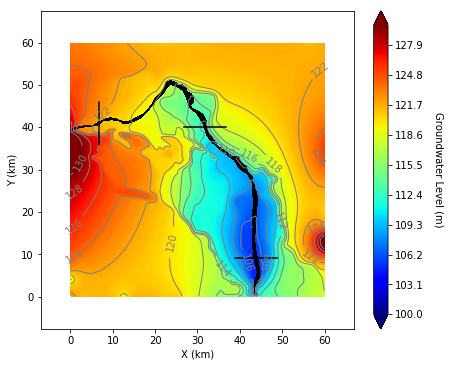

In [19]:
%matplotlib inline 

# loop over time step
for itime in time_index[-2:-1]:

    print(itime)
    # initialize total head
    temp_wl = np.asarray([np.nan] * (ny * nx)).reshape(ny, nx)
    # read pressure
    temp_pressure = np.asarray(list(input_h5[itime]["Liquid_Pressure [Pa]"]))
    # convert p to head
    temp_head = (temp_pressure - 101325) / 997.16 / 9.8068
    for ix in range(nx):
        for iy in range(ny):
            positive_head_index = np.where(temp_head[ix, iy, :] > 0)[0] # take the first positive head
            if (len(positive_head_index) > 0): # if positive head exists, then caculate total head
                iz = positive_head_index[0]
                temp_wl[iy, ix] = temp_head[ix, iy, iz] + z[iz] # for contour plot, temp_wl must has shape of (ny, nx)

    real_itime = batch_delta_to_time(date_origin, [float(
        itime[7:18])], "%Y-%m-%d %H:%M:%S", "hours")
    real_itime = str(real_itime[0])
    
    ## plot gw contour

    gs = gridspec.GridSpec(1, 1)
    fig = plt.figure()
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(line1_x, line1_y, "black")
    ax1.plot(line2_x, line2_y, "black")
    ax1.plot(line3_x, line3_y, "black")
    cf1 = ax1.contourf(x / 1000, y / 1000, temp_wl,
                       cmap=plt.cm.jet,
                       levels=np.arange(100, 130.1, 0.1),
                       vmin=100,
                       vmax=130,
                       extend="both",
                       V=np.arange(100, 130.1, 5)
                       )
    cf2 = ax1.contour(x / 1000, y / 1000, temp_wl,
                      colors="grey",
                      levels=np.arange(100, 130.1, 2),
                      linewidths=1,
                      vmin=100,
                      vmax=130)
    plt.clabel(cf2, inline = True, fmt = '%3.0d', fontsize = 10)
    ax1.set_xlabel("X (km)")
    ax1.set_ylabel("Y (km)")
    ax1.set_aspect("equal", "datalim")
    ax1.set_xlim([np.min(x_grids) / 1000, np.max(x_grids) / 1000])
    ax1.set_ylim([np.min(x_grids) / 1000, np.max(x_grids) / 1000])
    ax1.set_aspect("equal", "datalim")
    cb1 = plt.colorbar(cf1, extend="both")  # ,
    #                           orientation="horizontal", shrink=0.8, aspect=25)
    cb1.ax.set_ylabel("Groundwater Level (m)", rotation=270, labelpad=20)
    fig.tight_layout()
    cf3 = ax1.contourf(x / 1000, y / 1000, yx_river, colors="black")
    fig.set_size_inches(6.5, 5.5)

In [16]:
    fig_name = fig_wl + real_itime + ".png"
    fig.savefig(fig_name, dpi=100, transparent=False)
    plt.close(fig)
    

Time:  6.22680E+04 h
Time:  6.22740E+04 h
Time:  6.22800E+04 h
Time:  6.22860E+04 h
Time:  6.22920E+04 h
Time:  6.22980E+04 h
Time:  6.23040E+04 h
Time:  6.23100E+04 h
Time:  6.23160E+04 h
Time:  6.23220E+04 h
Time:  6.23280E+04 h
Time:  6.23340E+04 h
Time:  6.23400E+04 h
Time:  6.23460E+04 h
Time:  6.23520E+04 h
Time:  6.23580E+04 h
Time:  6.23640E+04 h
Time:  6.23700E+04 h
Time:  6.23760E+04 h
Time:  6.23820E+04 h
Time:  6.23880E+04 h
Time:  6.23940E+04 h
Time:  6.24000E+04 h
Time:  6.24060E+04 h
Time:  6.24120E+04 h
Time:  6.24180E+04 h
Time:  6.24240E+04 h
Time:  6.24300E+04 h
Time:  6.24360E+04 h
Time:  6.24420E+04 h
Time:  6.24480E+04 h
Time:  6.24540E+04 h
Time:  6.24600E+04 h
Time:  6.24660E+04 h
Time:  6.24720E+04 h
Time:  6.24780E+04 h
Time:  6.24840E+04 h
Time:  6.24900E+04 h
Time:  6.24960E+04 h
Time:  6.25020E+04 h
Time:  6.25080E+04 h
Time:  6.25140E+04 h
Time:  6.25200E+04 h
Time:  6.25260E+04 h
Time:  6.25320E+04 h
Time:  6.25380E+04 h
Time:  6.25440E+04 h
Time:  6.2550

Time:  6.46140E+04 h
Time:  6.46200E+04 h
Time:  6.46260E+04 h
Time:  6.46320E+04 h
Time:  6.46380E+04 h
Time:  6.46440E+04 h
Time:  6.46500E+04 h
Time:  6.46560E+04 h
Time:  6.46620E+04 h
Time:  6.46680E+04 h
Time:  6.46740E+04 h
Time:  6.46800E+04 h
Time:  6.46860E+04 h
Time:  6.46920E+04 h
Time:  6.46980E+04 h
Time:  6.47040E+04 h
Time:  6.47100E+04 h
Time:  6.47160E+04 h
Time:  6.47220E+04 h
Time:  6.47280E+04 h
Time:  6.47340E+04 h
Time:  6.47400E+04 h
Time:  6.47460E+04 h
Time:  6.47520E+04 h
Time:  6.47580E+04 h
Time:  6.47640E+04 h
Time:  6.47700E+04 h
Time:  6.47760E+04 h
Time:  6.47820E+04 h
Time:  6.47880E+04 h
Time:  6.47940E+04 h
Time:  6.48000E+04 h
Time:  6.48060E+04 h
Time:  6.48120E+04 h
Time:  6.48180E+04 h
Time:  6.48240E+04 h
Time:  6.48300E+04 h
Time:  6.48360E+04 h
Time:  6.48420E+04 h
Time:  6.48480E+04 h
Time:  6.48540E+04 h
Time:  6.48600E+04 h
Time:  6.48660E+04 h
Time:  6.48720E+04 h
Time:  6.48780E+04 h
Time:  6.48840E+04 h
Time:  6.48900E+04 h
Time:  6.4896

Time:  6.69600E+04 h
Time:  6.69660E+04 h
Time:  6.69720E+04 h
Time:  6.69780E+04 h
Time:  6.69840E+04 h
Time:  6.69900E+04 h
Time:  6.69960E+04 h
Time:  6.70020E+04 h
Time:  6.70080E+04 h
Time:  6.70140E+04 h
Time:  6.70200E+04 h
Time:  6.70260E+04 h
Time:  6.70320E+04 h
Time:  6.70380E+04 h
Time:  6.70440E+04 h
Time:  6.70500E+04 h
Time:  6.70560E+04 h
Time:  6.70620E+04 h
Time:  6.70680E+04 h
Time:  6.70740E+04 h
Time:  6.70800E+04 h
Time:  6.70860E+04 h
Time:  6.70920E+04 h
Time:  6.70980E+04 h
Time:  6.71040E+04 h
Time:  6.71100E+04 h
Time:  6.71160E+04 h
Time:  6.71220E+04 h
Time:  6.71280E+04 h
Time:  6.71340E+04 h
Time:  6.71400E+04 h
Time:  6.71460E+04 h
Time:  6.71520E+04 h
Time:  6.71580E+04 h
Time:  6.71640E+04 h
Time:  6.71700E+04 h
Time:  6.71760E+04 h
Time:  6.71820E+04 h
Time:  6.71880E+04 h
Time:  6.71940E+04 h
Time:  6.72000E+04 h
Time:  6.72060E+04 h
Time:  6.72120E+04 h
Time:  6.72180E+04 h
Time:  6.72240E+04 h
Time:  6.72300E+04 h
Time:  6.72360E+04 h
Time:  6.7242

Time:  6.93060E+04 h
Time:  6.93120E+04 h
Time:  6.93180E+04 h
Time:  6.93240E+04 h
Time:  6.93300E+04 h
Time:  6.93360E+04 h
Time:  6.93420E+04 h
Time:  6.93480E+04 h
Time:  6.93540E+04 h
Time:  6.93600E+04 h
Time:  6.93660E+04 h
Time:  6.93720E+04 h
Time:  6.93780E+04 h
Time:  6.93840E+04 h
Time:  6.93900E+04 h
Time:  6.93960E+04 h
Time:  6.94020E+04 h
Time:  6.94080E+04 h
Time:  6.94140E+04 h
Time:  6.94200E+04 h
Time:  6.94260E+04 h
Time:  6.94320E+04 h
Time:  6.94380E+04 h
Time:  6.94440E+04 h
Time:  6.94500E+04 h
Time:  6.94560E+04 h
Time:  6.94620E+04 h
Time:  6.94680E+04 h
Time:  6.94740E+04 h
Time:  6.94800E+04 h
Time:  6.94860E+04 h
Time:  6.94920E+04 h
Time:  6.94980E+04 h
Time:  6.95040E+04 h
Time:  6.95100E+04 h
Time:  6.95160E+04 h
Time:  6.95220E+04 h
Time:  6.95280E+04 h
Time:  6.95340E+04 h
Time:  6.95400E+04 h
Time:  6.95460E+04 h
Time:  6.95520E+04 h
Time:  6.95580E+04 h
Time:  6.95640E+04 h
Time:  6.95700E+04 h
Time:  6.95760E+04 h
Time:  6.95820E+04 h
Time:  6.9588

Time:  7.16520E+04 h
Time:  7.16580E+04 h
Time:  7.16640E+04 h
Time:  7.16700E+04 h
Time:  7.16760E+04 h
Time:  7.16820E+04 h
Time:  7.16880E+04 h
Time:  7.16940E+04 h
Time:  7.17000E+04 h
Time:  7.17060E+04 h
Time:  7.17120E+04 h
Time:  7.17180E+04 h
Time:  7.17240E+04 h
Time:  7.17300E+04 h
Time:  7.17360E+04 h
Time:  7.17420E+04 h
Time:  7.17480E+04 h
Time:  7.17540E+04 h
Time:  7.17600E+04 h
Time:  7.17660E+04 h
Time:  7.17720E+04 h
Time:  7.17780E+04 h
Time:  7.17840E+04 h
Time:  7.17900E+04 h
Time:  7.17960E+04 h
Time:  7.18020E+04 h
Time:  7.18080E+04 h
Time:  7.18140E+04 h
Time:  7.18200E+04 h
Time:  7.18260E+04 h
Time:  7.18320E+04 h
Time:  7.18380E+04 h
Time:  7.18440E+04 h
Time:  7.18500E+04 h
Time:  7.18560E+04 h
Time:  7.18620E+04 h
Time:  7.18680E+04 h
Time:  7.18740E+04 h
Time:  7.18800E+04 h
Time:  7.18860E+04 h
Time:  7.18920E+04 h
Time:  7.18980E+04 h
Time:  7.19040E+04 h
Time:  7.19100E+04 h
Time:  7.19160E+04 h
Time:  7.19220E+04 h
Time:  7.19280E+04 h
Time:  7.1934

Time:  7.39980E+04 h
Time:  7.40040E+04 h
Time:  7.40100E+04 h
Time:  7.40160E+04 h
Time:  7.40220E+04 h
Time:  7.40280E+04 h
Time:  7.40340E+04 h
Time:  7.40400E+04 h
Time:  7.40460E+04 h
Time:  7.40520E+04 h
Time:  7.40580E+04 h
Time:  7.40640E+04 h
Time:  7.40700E+04 h
Time:  7.40760E+04 h
Time:  7.40820E+04 h
Time:  7.40880E+04 h
Time:  7.40940E+04 h
Time:  7.41000E+04 h
Time:  7.41060E+04 h
Time:  7.41120E+04 h
Time:  7.41180E+04 h
Time:  7.41240E+04 h
Time:  7.41300E+04 h
Time:  7.41360E+04 h
Time:  7.41420E+04 h
Time:  7.41480E+04 h
Time:  7.41540E+04 h
Time:  7.41600E+04 h
Time:  7.41660E+04 h
Time:  7.41720E+04 h
Time:  7.41780E+04 h
Time:  7.41840E+04 h
Time:  7.41900E+04 h
Time:  7.41960E+04 h
Time:  7.42020E+04 h
Time:  7.42080E+04 h
Time:  7.42140E+04 h
Time:  7.42200E+04 h
Time:  7.42260E+04 h
Time:  7.42320E+04 h
Time:  7.42380E+04 h
Time:  7.42440E+04 h
Time:  7.42500E+04 h
Time:  7.42560E+04 h
Time:  7.42620E+04 h
Time:  7.42680E+04 h
Time:  7.42740E+04 h
Time:  7.4280

Time:  7.63440E+04 h
Time:  7.63500E+04 h
Time:  7.63560E+04 h
Time:  7.63620E+04 h
Time:  7.63680E+04 h
Time:  7.63740E+04 h
Time:  7.63800E+04 h
Time:  7.63860E+04 h
Time:  7.63920E+04 h
Time:  7.63980E+04 h
Time:  7.64040E+04 h
Time:  7.64100E+04 h
Time:  7.64160E+04 h
Time:  7.64220E+04 h
Time:  7.64280E+04 h
Time:  7.64340E+04 h
Time:  7.64400E+04 h
Time:  7.64460E+04 h
Time:  7.64520E+04 h
Time:  7.64580E+04 h
Time:  7.64640E+04 h
Time:  7.64700E+04 h
Time:  7.64760E+04 h
Time:  7.64820E+04 h
Time:  7.64880E+04 h
Time:  7.64940E+04 h
Time:  7.65000E+04 h
Time:  7.65060E+04 h
Time:  7.65120E+04 h
Time:  7.65180E+04 h
Time:  7.65240E+04 h
Time:  7.65300E+04 h
Time:  7.65360E+04 h
Time:  7.65420E+04 h
Time:  7.65480E+04 h
Time:  7.65540E+04 h
Time:  7.65600E+04 h
Time:  7.65660E+04 h
Time:  7.65720E+04 h
Time:  7.65780E+04 h
Time:  7.65840E+04 h
Time:  7.65900E+04 h
Time:  7.65960E+04 h
Time:  7.66020E+04 h
Time:  7.66080E+04 h
Time:  7.66140E+04 h
Time:  7.66200E+04 h
Time:  7.6626

# export gw data

In [20]:
for itime in time_index[-2:-1]:

    print(itime)
    # initialize total head
    temp_wl = np.asarray([np.nan] * (ny * nx)).reshape(ny, nx)
    # read pressure
    temp_pressure = np.asarray(list(input_h5[itime]["Liquid_Pressure [Pa]"]))
    # convert p to head
    temp_head = (temp_pressure - 101325) / 997.16 / 9.8068
    for ix in range(nx):
        for iy in range(ny):
            positive_head_index = np.where(temp_head[ix, iy, :] > 0)[0] # take the first positive head
            if (len(positive_head_index) > 0): # if positive head exists, then caculate total head
                iz = positive_head_index[0]
                temp_wl[iy, ix] = temp_head[ix, iy, iz] + z[iz]

    real_itime = batch_delta_to_time(date_origin, [float(
        itime[7:18])], "%Y-%m-%d %H:%M:%S", "hours")
    real_itime = str(real_itime[0])
    print(real_itime)
    
    np.savetxt(fig_wl + real_itime + '.csv', temp_wl, delimiter= ',')

Time:  7.67880E+04 h
2015-12-31 00:00:00


In [12]:
input_h5.close()